### Helper

In [1]:
import os
import sys

# to import functions from `patching_utils.py` and `plotly_utils.py`,
# we need to add the repository directory to the system path.
project_base_dir = os.path.dirname(os.path.dirname(os.getcwd()))
print(project_base_dir)
if project_base_dir not in sys.path:
    sys.path.append(project_base_dir)

/home/qinyuan/function-induction


In [2]:
import torch as t
from torch import Tensor
import torch.nn.functional as F

from transformer_lens import HookedTransformer, patching, ActivationCache, utils
from transformer_lens.hook_points import HookPoint

t.set_grad_enabled(False)

from jaxtyping import Float, Int, Bool
from typing import Literal, Callable, Dict, Tuple
from functools import partial

from IPython.display import display, HTML
from plotly_utils import imshow, line, scatter, bar
from patching_utils import prepare_data_for_fwd

from tqdm import trange

/home/qinyuan/miniconda3/envs/ts/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = "cuda:0"
model_name = "google/gemma-2-9b"

model = HookedTransformer.from_pretrained(model_name, device=device)
model.set_ungroup_grouped_query_attention(True)

Loading checkpoint shards: 100%|██████████| 8/8 [00:01<00:00,  7.87it/s]


Loaded pretrained model google/gemma-2-9b into HookedTransformer


In [4]:
from data_utils import process_dataset, read_jsonl

def load_data(offset):
    setting, nmax, offset, n_icl_examples = "setting1", 9, offset, 4
    filename = f"../../data/addition/{setting}/addition_nmax{nmax}_offset{offset}.jsonl"
    data = read_jsonl(filename)
    processed_data = process_dataset(data, n_icl_examples=n_icl_examples, offset=offset)
    return processed_data

### Compute FVs

In [5]:
# 0-9 token ids
digit_token_ids = [235276, 235274, 235284, 235304, 235310, 235308, 235318, 235324, 235321, 235315]
# FI heads
# heads = [(39, 12), (39, 7), (36, 7), (32, 6), (32, 1), (25, 13), (32, 4), (28, 6), (24, 9), (36, 6)]
# PT heads
heads = [(38, 9), (38, 6), (38, 7), (35, 9), (35, 14), (31, 5), (31, 4), (29, 5)]
# Consolidation Heads
# heads = [(41, 4), (41, 5), (40, 11), (40, 12)]

In [6]:
data = load_data(1)
print(data[0])

{'normal_input': '4+3=7\n3+2=5\n6+0=6\n3+3=6\n1+0=', 'normal_output': '1', 'contrast_input': '4+3=8\n3+2=6\n6+0=7\n3+3=7\n1+0=', 'contrast_output': '2'}


In [26]:
fv_offset = {}
for offset in [1]:
    fvs = {}

    data = load_data(offset)
    batch_size = 4
    for st in trange(0, len(data), batch_size):
        ed = st + batch_size
        batch = data[st: ed]

        for head_layer, head_idx in heads:
            t.cuda.empty_cache()
            _, _, _, _, normal_cache, contrast_cache, normal_logits, contrast_logits = prepare_data_for_fwd(model, batch)
            
            # head_out = contrast_cache[utils.get_act_name("z", head_layer)][:, -1, head_idx, :]
            # -6 is the previous c
            head_out = contrast_cache[utils.get_act_name("z", head_layer)][:, [-24,-18,-12,-6], head_idx, :].mean(dim=1)

            if (head_layer, head_idx) in fvs:
                fvs[(head_layer, head_idx)].append(head_out)
            else:
                fvs[(head_layer, head_idx)] = [head_out]
            del contrast_cache
            del normal_cache
    
    for head_layer, head_idx in heads:
        tensors = fvs[(head_layer, head_idx)]
        fvs[(head_layer, head_idx)] = t.cat(tensors, dim=0).mean(dim=0)

    fv_offset[offset] = fvs

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [01:43<00:00,  4.15s/it]


In [27]:
print(fv_offset[1][(38, 9)].shape)

torch.Size([256])


### Getting Naive Prompt Logits

In [44]:
# 2-shot
# prompts = ["{}={}\n{}={}\n{}=".format((i-2) % 10, (i-2) % 10, (i-1) % 10, (i-1) % 10, i, i) for i in range(10)]
# 1-shot
prompts = ["{}={}\n{}=".format((i-1) % 10, (i-1) % 10, i, i) for i in range(10)]
print(prompts)

['9=9\n0=', '0=0\n1=', '1=1\n2=', '2=2\n3=', '3=3\n4=', '4=4\n5=', '5=5\n6=', '6=6\n7=', '7=7\n8=', '8=8\n9=']


In [45]:
digit_logits = model.forward(prompts) # batch_size * seqlen * vocab_size
digit_logits = digit_logits[:, -1, digit_token_ids] # batch_size, 0-9

In [46]:
imshow(digit_logits,
    labels={"x": "Output", "y": "Input"},
    title="Clean Baseline",
    width=400,
    height=400,
    zmin=24,
    zmax=30,
    color_continuous_scale="Blues"
)

### Apply FVs to Naive Prompts

In [47]:
def apply_fv_hook(
    head_out: Float[Tensor, "batch pos d_model"],
    hook: HookPoint,
    head_idx: int,
    fvs: Dict[Tuple[int, int], Tensor],
) -> Float[Tensor, "batch pos d_model"]:
    # head_out[:, -1, head_idx, :] += fvs[(hook.layer(), head_idx)]
    # -4 is the answer in the previous ICL example
    head_out[:, -4, head_idx, :] += fvs[(hook.layer(), head_idx)]
    # head_out[:, -8, head_idx, :] += fvs[(hook.layer(), head_idx)]

In [48]:
head_diffs_offset = {}
for offset in [1]:
    head_diffs = {}
    for head_layer, head_idx in heads:
        fwd_hooks = [(utils.get_act_name("z", head_layer), partial(apply_fv_hook, head_idx=head_idx, fvs=fv_offset[offset]))]
        fv_applied_logits = model.run_with_hooks(prompts, fwd_hooks=fwd_hooks)

        fv_applied_logits = fv_applied_logits[:, -1, digit_token_ids] # batch_size x [0-9]

        diff = fv_applied_logits - digit_logits
        head_diffs[(head_layer, head_idx)] = diff
    head_diffs_offset[offset] = head_diffs

In [49]:
# aggregated effect of 4 heads
aggregated_diff = {}
for offset in [1]:

    fwd_hooks = [(utils.get_act_name("z", head_layer), partial(apply_fv_hook, head_idx=head_idx, fvs=fv_offset[offset])) for head_layer, head_idx in heads]
    fv_applied_logits = model.run_with_hooks(prompts, fwd_hooks=fwd_hooks)

    fv_applied_logits = fv_applied_logits[:, -1, digit_token_ids] # batch_size x [0-9]

    diff = fv_applied_logits - digit_logits
    normalized_diff = diff - diff.mean(0).mean(0)
    aggregated_diff[offset] = normalized_diff


### Plotting

In [50]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.sans-serif'] = 'DejaVu Serif' 

#### Individual effect and aggregated effect

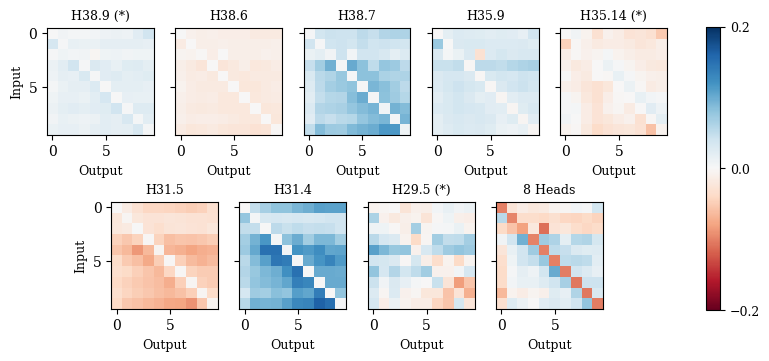

In [70]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

offset = 1

heads_display_order = heads
# heads_display_order = [(25,13)] + [(32,4), (28,6), (24,9)] 
matrices = [head_diffs_offset[offset][(layer, idx)].cpu().numpy() for layer, idx in heads_display_order] + [aggregated_diff[offset].cpu().numpy()]
titles =  [f"H{l}.{h}" for l, h in heads_display_order] + ["8 Heads"]
for i in [0, 4, 7]:
    titles[i] += " (*)"

# Create figure with GridSpec: 2 rows, 10 columns
fig = plt.figure(figsize=(10, 4))
gs = gridspec.GridSpec(2, 10, figure=fig, wspace=0.5, hspace=0.3)

axes = []

# Top row: 5 subplots filling all 10 columns
for i in range(5):
    ax = fig.add_subplot(gs[0, 2*i:2*(i+1)])
    axes.append(ax)

# Bottom row: 4 subplots, centered (leave 1 col margin on each side)
for i in range(4):
    ax = fig.add_subplot(gs[1, 1+2*i:1+2*(i+1)])
    axes.append(ax)

# Plot each matrix
for i, (ax, matrix, title) in enumerate(zip(axes, matrices, titles)):
    if i in [0, 4, 7]:
        im = ax.imshow(matrix, cmap="RdBu", vmin=-0.02, vmax=0.02)
    else:
        im = ax.imshow(matrix, cmap="RdBu", vmin=-0.2, vmax=0.2)
    ax.set_title(title, fontsize=9)
    ax.set_xlabel("Output", fontsize=9)
    if i in [0, 5]:  # first in each row
        ax.set_ylabel("Input", fontsize=9)
    else:
        ax.set_yticks([0, 5])
        ax.set_yticklabels(["",""])

# Add shared colorbar
cbar = fig.colorbar(im, ax=axes, shrink=0.92, ticks=[-0.2, 0, 0.2])
cbar.ax.tick_params(labelsize=9)

# plt.tight_layout()
plt.savefig("figures/gemma_2_pt_head_offset{}.pdf".format(offset), dpi=300, bbox_inches='tight', pad_inches=0.0)
plt.show()
